In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import os
import random

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import torch
from torch import nn
import torch.nn.functional as F


from torch.utils.tensorboard import SummaryWriter


In [3]:
# specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
# reproducibility
RANDOM_STATE = 0
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)



## Data Loading

In [5]:
DIR = os.getcwd()
if DIR.endswith("code"):
    DIR = DIR[:-5]
SAVED_IN = os.path.abspath(DIR + "/models" + "/CNN_complex")
Path(SAVED_IN).mkdir(parents=True, exist_ok=True)
print(f"saved in: {SAVED_IN}")

from utils.plot_util import plot_one_gt_train_test, plot_gt_pre_overlap, plot_3_losses
from utils.data_util import (
    dotdict,
    extract_pos_s21_offset,
    load_pos_s21,
    save_pre,
    load_pre,
    PreprocessedDataset,
    get_dataloader,
)
from utils.nn_util import train_NN, count_parameters
from utils.complex_util import dict_act_complex, complex_normalize

saved in: c:\Users\xinch\Desktop\RBI\models\CNN_complex_fe


## Data Extraction

In [6]:
# load data
folder = os.path.join(DIR, "data")
data_file_name = os.path.join(folder, "data_offset_complex.pkl")
pos, s21, pos_TEST, s21_TEST = load_pos_s21(data_file_name, 5)

X = s21
Y = pos

X_TEST = s21_TEST
y_TEST = pos_TEST


## Data Preprocessing

### Train test split wit indicies

In [7]:
indices = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, Y, indices, test_size=0.2, random_state=RANDOM_STATE
)
idx_train_sort = np.sort(idx_train)
idx_test_sort = np.sort(idx_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(411257, 121)
(411257,)
(102815, 121)
(102815,)


### Normalization

In [8]:
X_train_scaled, X_train_mean, X_train_std = complex_normalize(X_train)
X_test_scaled, X_test_mean, X_test_std = complex_normalize(X_test, X_train_mean, X_train_std)
X_TEST_scaled, X_TEST_mean, X_TEST_std = complex_normalize(X_TEST, X_train_mean, X_train_std)

X_scaled = np.zeros_like(X)
X_scaled[idx_train] = X_train_scaled
X_scaled[idx_test] = X_test_scaled

y_train = Y[idx_train].reshape(-1, 1)  # reshape to (N,1)
y_test = Y[idx_test].reshape(-1, 1)  # reshape to (N,1)
y_TEST = y_TEST.reshape(-1, 1)  # reshape to (N,1)

# add channel dimension for CNN
X_train_scaled = np.expand_dims(X_train_scaled,1)
X_test_scaled = np.expand_dims(X_test_scaled,1)
X_TEST_scaled = np.expand_dims(X_TEST_scaled,1)

print(X_train_scaled.shape)
print(y_train.shape)
print(X_test_scaled.shape)
print(y_test.shape)
print(X_TEST_scaled.shape)
print(y_TEST.shape)


(411257, 1, 121)
(411257, 1)
(102815, 1, 121)
(102815, 1)
(20135, 1, 121)
(20135, 1)


# CNN

In [9]:

from utils.complexPyTorch.complexLayers import ComplexConv1d, ComplexBatchNorm1d, ComplexLinear, ComplexReLU, ComplexSigmoid, ComplexTanh, ComplexDropout

class CNN_baseline_complex(nn.Module):
    def __init__(
        self, 
        base_channels,
        activation_fn, 
        use_dropout=False, 
        use_bn=False
    ):
        super().__init__()

        self.conv1 = ComplexConv1d(in_channels =1, out_channels=base_channels, kernel_size=11, stride=5, padding=0)
        self.conv2 = ComplexConv1d(in_channels =base_channels, out_channels=2*base_channels, kernel_size=3, stride=2, padding=0)
        self.conv3 = ComplexConv1d(in_channels =2*base_channels, out_channels=4*base_channels, kernel_size=3, stride=2, padding=0)
        self.conv4 = ComplexConv1d(in_channels =4*base_channels, out_channels=8*base_channels, kernel_size=3, stride=1, padding=0)
        self.conv5 = ComplexConv1d(in_channels =8*base_channels, out_channels=8*base_channels, kernel_size=3, stride=1, padding=0)

        # self.pool = ComplexMaxPool1d(2, 2)

        self.fc = nn.Linear(in_features=1*2*8*base_channels, out_features=1) # TODO, 1 here is derived by the model structure

        self.conv_block1 = self.generate_conv_block(self.conv1, activation_fn, use_dropout, use_bn)
        self.conv_block2 = self.generate_conv_block(self.conv2, activation_fn, use_dropout, use_bn)
        self.conv_block3 = self.generate_conv_block(self.conv3, activation_fn, use_dropout, use_bn)
        self.conv_block4 = self.generate_conv_block(self.conv4, activation_fn, use_dropout, use_bn)
        self.conv_block5 = self.generate_conv_block(self.conv5, activation_fn, use_dropout, use_bn)

    def generate_conv_block(self, conv, activation_fn, use_dropout, use_bn):
        """conv-bn-activation-dropout"""
        layers = []
        layers.append(conv) 
        if use_bn:
            layers.append(ComplexBatchNorm1d(conv.out_channels))
        layers.append(activation_fn)
        if use_dropout:
            layers.append(ComplexDropout(0.5))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)
        x = torch.flatten(x,1)
        x = torch.cat((x.real,x.imag),dim=1)
        x = self.fc(x)
        return x

## base channel 4

### Init

In [14]:
# configuration
_config = {
    "base_channels": 4,
    "activation": "sigmoid",
    "batch_size": 64,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  # default value
    "weight_decay": 0.001,
    "betas": (0.9, 0.999),  # default value
    "use_dropout": False,
    "use_bn": False,
}

# dot access
config = dotdict(_config)

# ## define the model
MODEL_NAME = "cnn_baseline.pth"
model = CNN_baseline_complex(
    base_channels=config.base_channels,
    activation_fn=dict_act_complex[config.activation],
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
).to(device)
# summary(model, input_size=(1, 242)) # somethings wrong with this
count_parameters(model)


10513

In [15]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [16]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [17]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [18]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

[W Copy.cpp:244] Warning: Casting complex values to real discards the imaginary part (function operator())


epoch : 0, train loss : 965.57, test loss : 860.22, TEST loss : 854.92, lr: 0.0010
epoch : 10, train loss : 66.03, test loss : 50.04, TEST loss : 53.74, lr: 0.0010
epoch : 20, train loss : 10.01, test loss : 9.55, TEST loss : 16.68, lr: 0.0010
epoch : 30, train loss : 5.47, test loss : 4.82, TEST loss : 8.50, lr: 0.0010
epoch : 40, train loss : 3.59, test loss : 4.12, TEST loss : 8.31, lr: 0.0010
epoch : 50, train loss : 2.82, test loss : 2.51, TEST loss : 6.89, lr: 0.0010
epoch : 60, train loss : 2.37, test loss : 2.09, TEST loss : 5.26, lr: 0.0010
epoch : 70, train loss : 2.06, test loss : 2.34, TEST loss : 3.84, lr: 0.0010
epoch : 80, train loss : 1.81, test loss : 1.88, TEST loss : 3.00, lr: 0.0010
epoch : 90, train loss : 1.64, test loss : 1.64, TEST loss : 2.50, lr: 0.0010
epoch : 100, train loss : 1.51, test loss : 1.58, TEST loss : 2.42, lr: 0.0010
epoch : 110, train loss : 1.39, test loss : 1.29, TEST loss : 1.96, lr: 0.0010
epoch : 120, train loss : 1.32, test loss : 1.17, TE

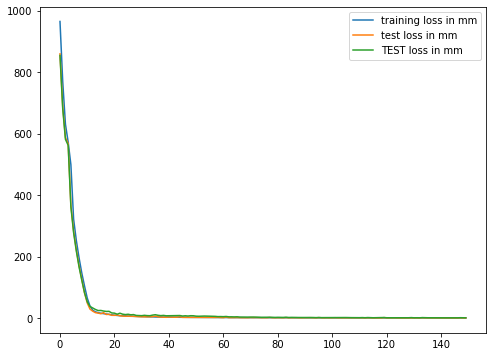

In [19]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [20]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


CNN_baseline_complex(
  (conv1): ComplexConv1d(
    (conv_r): Conv1d(1, 4, kernel_size=(11,), stride=(5,))
    (conv_i): Conv1d(1, 4, kernel_size=(11,), stride=(5,))
  )
  (conv2): ComplexConv1d(
    (conv_r): Conv1d(4, 8, kernel_size=(3,), stride=(2,))
    (conv_i): Conv1d(4, 8, kernel_size=(3,), stride=(2,))
  )
  (conv3): ComplexConv1d(
    (conv_r): Conv1d(8, 16, kernel_size=(3,), stride=(2,))
    (conv_i): Conv1d(8, 16, kernel_size=(3,), stride=(2,))
  )
  (conv4): ComplexConv1d(
    (conv_r): Conv1d(16, 32, kernel_size=(3,), stride=(1,))
    (conv_i): Conv1d(16, 32, kernel_size=(3,), stride=(1,))
  )
  (conv5): ComplexConv1d(
    (conv_r): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
    (conv_i): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  )
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (conv_block1): Sequential(
    (0): ComplexConv1d(
      (conv_r): Conv1d(1, 4, kernel_size=(11,), stride=(5,))
      (conv_i): Conv1d(1, 4, kernel_size=(11,), stride=(5,))
   

In [21]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.from_numpy(np.expand_dims(X_scaled,1)).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.from_numpy(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")


train RMSE: 1.00 mm
test RMSE: 1.00 mm
TEST RMSE: 1.53 mm


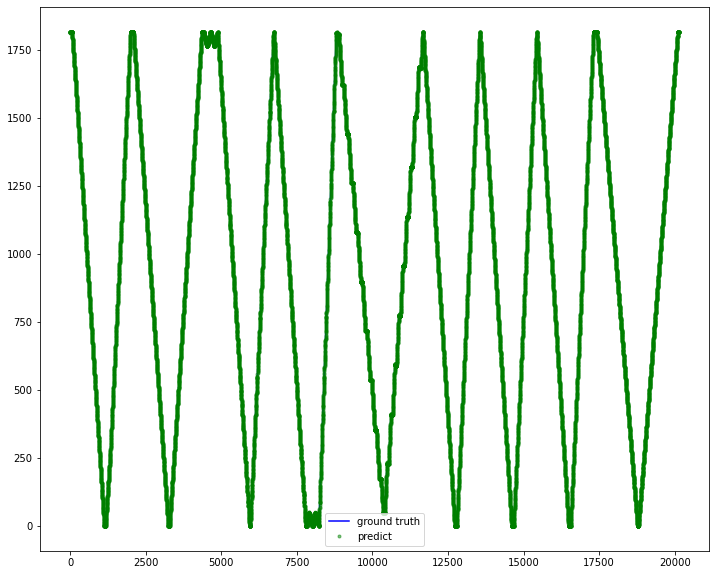

In [22]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


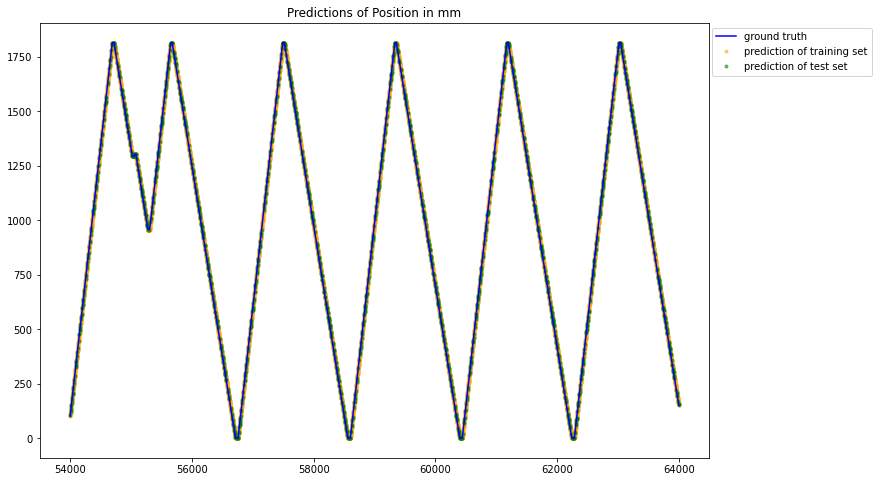

In [23]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)
